<table align="center" width=100%>
    <tr>
        <td width="15%">
            <img src="in_class.png">
        </td>
        <td>
            <div align="center">
                <font color="#21618C" size=8px>
                    <b> Inclass - Lab <br>(Session 3)
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

### About the data set (Bank Client Data)

#### Bank client data:
**age:** Age of the client<br>
**duration:** last contact duration, in seconds.<br> 

#### Other attributes:
**campaign:** number of contacts performed during this campaign and for this client<br>
**pdays:** number of days that passed by after the client was last contacted from a previous campaign (999 means client was not previously contacted)<br>
**previous:** number of contacts performed before this campaign and for this client<br>

#### Social and economic context attributes
**emp.var.rate:** employment variation rate - quarterly indicator<br>
**cons.price.idx:** consumer price index - monthly indicator<br>
**cons.conf.idx:** consumer confidence index - monthly indicator<br>
**euribor3m:** euribor 3 month rate - daily indicator<br>
**nr.employed:** number of employees - quarterly indicator<br>

**y** - (Output variable) has the client subscribed a term deposit?

## Table of Content

1. **[Data Preprocessing](#dp)**
1. **[K Nearest Neighbors (KNN)](#knn)**


**Import the required libraries**

In [163]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler 

from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix



from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


#### Load the csv file

In [164]:
df = pd.read_csv('bank.csv')
df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,32,205,2,999,0,1.1,93.994,-36.4,4.858,5191.0,no
1,32,691,10,999,0,1.4,93.918,-42.7,4.960,5228.1,yes
2,45,45,8,999,0,1.4,93.444,-36.1,4.963,5228.1,no
3,33,400,1,5,2,-1.1,94.601,-49.5,1.032,4963.6,yes
4,47,903,2,999,1,-1.8,93.075,-47.1,1.415,5099.1,yes


In [165]:
df.dtypes

age                 int64
duration            int64
campaign            int64
pdays               int64
previous            int64
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

<a id="dp"> </a>
## 1. Data Preprocessing

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>1. Remove the outliers (if any).</b>
                </font>
            </div>
        </td>
    </tr>
</table>

**Outlier analysis**

In [166]:
# check the size of data
df.shape

(9640, 11)

In [167]:
# calculate the first quartile
Q1 = df.quantile(0.25)
#calculate the third quartile
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
# remove the outliers from the dataframe
df = df[~((df< (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
# reset the row index
df = df.reset_index(drop=True)
# check the shape of the data
df.shape

(6555, 11)

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>2. Separate the dependent and the independent variables. Also, in the target variable, replace yes with 0 and no with 1.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

#### Split the dependent and independent variables.

In [168]:
# store the target variable "y" in a dataframe 'df_target'
df_target = df['y']


df_feature = df.drop('y', axis = 1)

In [169]:
# if the value in the target variable is 'yes' then replace it with 0 else with 1
for i in range(len(df_target)):
    if df_target[i] == 'yes':
        df_target[i] = 0
    else:
        df_target[i] = 1
        
# change the datatype of the target variable to integer
df_target = df_target.astype('int')

<ipython-input-169-92fa96fb1c49>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target[i] = 1
<ipython-input-169-92fa96fb1c49>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target[i] = 0


<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>4. Look for the null values and treat the null values.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

First run a check for the presence of missing values and their percentage for each column. Then choose the right approach to treat them.

In [170]:
Total = df_feature.isnull().sum()        
Total

age               0
duration          0
campaign          0
pdays             0
previous          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
dtype: int64

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>5. Remove the unnecessary variables that will not contribute to the model.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [171]:
# find the standard deviation for the numeric variables
df_feature.std()

age                10.184894
duration          253.406706
campaign            1.283539
pdays               0.000000
previous            0.000000
emp.var.rate        1.626927
cons.price.idx      0.585132
cons.conf.idx       4.659679
euribor3m           1.779666
nr.employed        74.431765
dtype: float64

**Interpretation:** The variables `pdays` and `previous` have standard deviation 0.

In [172]:
# create a list of the columns to drop
#c1 = ['pdays', 'previous']
df_feature = df_feature.drop(columns=['pdays', 'previous'], axis=1)
df_feature.shape

(6555, 8)

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>7.  distribution of the target variable.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [173]:
print(df_target.value_counts())

1    4055
0    2500
Name: y, dtype: int64


<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>8. Scale all the numeric variables using standard scalar.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

We scale the variables to get all the variables in the same range. With this, we can avoid a problem in which some features come to dominate solely because they tend to have larger values than others.

In [174]:
# initialize the standard scalar
s = StandardScaler()
df_scaled = s.fit_transform(df_feature)
X = pd.DataFrame(df_scaled, columns = df_feature.columns)

# display first five observations
X.head()

,age,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,-0.722787,-0.480765,-0.024486,0.701361,0.749298,0.910658,0.765585,0.394074
1,-1.410132,-0.330797,0.754670,-1.081276,-1.217928,-2.008221,-1.104009,-0.840708
2,-0.330018,-0.445246,-0.803642,-0.036282,-0.607764,-0.291233,0.350869,0.458567
3,0.357326,0.880787,-0.803642,0.701361,0.749298,0.910658,0.765023,0.394074
4,1.241055,-1.037225,-0.803642,0.701361,0.749298,0.910658,0.763899,0.394074


<a id="knn"> </a>
## 2. K Nearest Neighbors (KNN)

## We shall use the bank marketing dataset that we cleaned above

Before applying classification techniques to predict whether the client subscribed the term deposit or not, let us split the dataset in train and test set.

random_state--Controls the shuffling applied to the data before applying the split.

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, df_target,random_state=10, test_size = 0.2)


print('X_train', X_train.shape)
print('y_train', y_train.shape)


print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (5244, 8)
y_train (5244,)
X_test (1311, 8)
y_test (1311,)


<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>10. Build a knn model on a training dataset using euclidean distance to predict whether or not the client subscribed the term deposit. Calculate the accuracy of the model.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [157]:
# default metric is minkowski, and with p=2 it is equivalent to the euclidean metric
knn = KNeighborsClassifier(n_neighbors = 3, metric='euclidean')
knn_model = knn.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.8497330282227308


<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>11. Show confusion matrix and print a classification report. </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [159]:
confusion_matrix(y_test, y_pred)


array([[399,  93],
       [104, 715]], dtype=int64)

In [162]:
# print the classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       492
           1       0.88      0.87      0.88       819

    accuracy                           0.85      1311
   macro avg       0.84      0.84      0.84      1311
weighted avg       0.85      0.85      0.85      1311



In [137]:
roc_auc_score(y_test, y_pred)

0.8419957413859854

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>12. Find the optimal value of 'k' in knn with 3 fold cross validation.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [89]:
tuned_paramaters = {'n_neighbors': np.arange(1, 25, 2),
                   'metric': ['hamming','euclidean','manhattan','Chebyshev']}
 
# instantiate the 'KNeighborsClassifier' 
knn_classification = KNeighborsClassifier(n_jobs=-1)

# use GridSearchCV() to find the optimal value of the hyperparameters
# estimator: pass the knn model
# param_grid: pass the list 'tuned_parameters'
# cv: number of folds in k-fold i.e. here cv = 3
knn_grid = GridSearchCV(estimator = knn_classification, 
                        param_grid = tuned_paramaters, 
                        cv = 3, 
                        scoring = 'accuracy', 
                        n_jobs=-1)

# fit the model on X_train and y_train using fit()
knn_grid.fit(X_train, y_train)

# get the best parameters
print('Best parameters for KNN Classifier: ', knn_grid.best_params_, '\n')

Best parameters for KNN Classifier:  {'metric': 'manhattan', 'n_neighbors': 15} 



<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>13.  Build a KNN model with the best parameters and find the accuracy. Also generate a classification report.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [90]:
# instantiate the 'KNeighborsClassifier'
# n_neighnors: number of neighbors to consider
# default metric is minkowski, and with p=2 it is equivalent to the euclidean metric
knn_classification = KNeighborsClassifier(n_neighbors = knn_grid.best_params_['n_neighbors'], 
                                          metric=knn_grid.best_params_['metric'])

# fit the model using fit() on train data
knn_model = knn_classification.fit(X_train, y_train)

# predict the attrition for test set
y_pred = knn_model.predict(X_test)

# pass the actual and predicted target values to the accuracy_score()
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.858886346300534


In [33]:
# print the classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       492
           1       0.91      0.86      0.88       819

    accuracy                           0.86      1311
   macro avg       0.85      0.86      0.85      1311
weighted avg       0.86      0.86      0.86      1311



<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>14. Find the area under the receiver operating characteristic curve and the confusion matrix for the tuned KNN model built in question 13.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

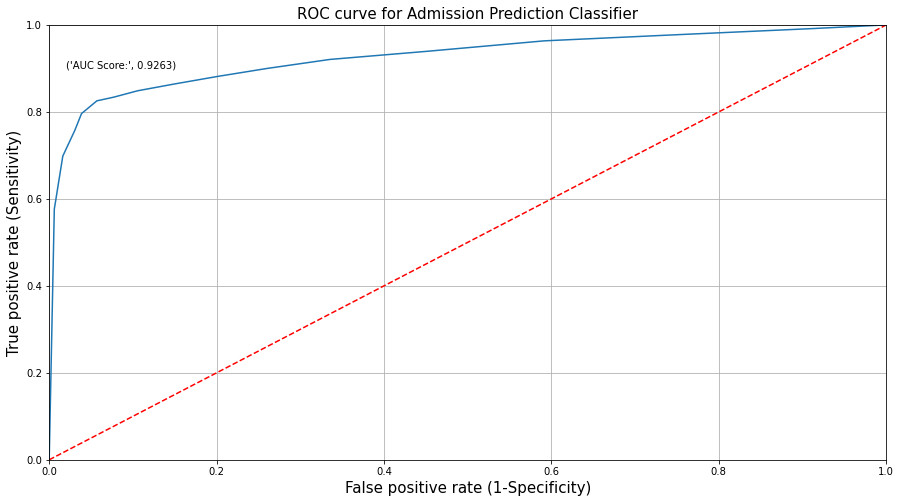

In [26]:
# plot the ROC curve
#plot_roc(knn_model)

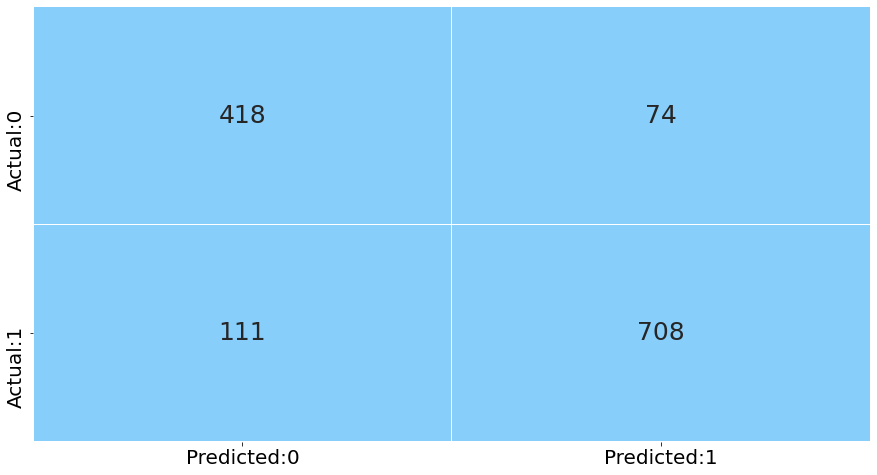

In [27]:
# call the function to plot the confusion matrix
# pass the knn model to the function
#plot_confusion_matrix(knn_model)

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>15. Calculate the percentage of misclassified and correctly classified observations.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [28]:
cm = confusion_matrix(y_pred, y_test)

total = cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0]

# find the percentage of correctly classified observations
# round the result upto 2 decimal points
correct_classified_percentage = ((cm[0][0]+cm[1][1])/total)*100
print("Percentage of correctly classified observations: ", round(correct_classified_percentage, 2))

# find the percentage of  misclassified observations
# round the result upto 2 decimal points
misclassified_percentage = ((cm[0][1]+cm[1][0])/total)*100
print("Percentage of misclassified observations: ", round(misclassified_percentage, 2))

Percentage of correctly classified observations:  85.89
Percentage of misclassified observations:  14.11


<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>16. Compute the accuracy for each value of k and append the value in a list 'accuracy'. Build knn models for distance metric 'euclidean'. Consider only the odd numbers for the 'k' between the range 1 and 25.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [29]:
# consider an empty list to store the accuracy
accuracy = []

# use for loop to build a knn model for each K
for i in np.arange(1,25,2):
    
    # setup a knn classifier with k neighbors
    # use the 'euclidean' metric 
    knn = KNeighborsClassifier(i, metric = 'euclidean', n_jobs=-1)
   
    # fit the model using 'cross_val_score'
    # pass the knn model as 'estimator'
    # use 3-fold cross validation
    score = cross_val_score(knn, X_train, y_train, cv = 3, n_jobs=-1)
    
    # calculate the mean score
    score = score.mean()
    
    # append the accuracy 
    accuracy.append(score)

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>17. Draw a line plot to see the accuracy (list created in the above question) for each value of K using euclidean distance as a metric of KNN model and find the optimal value of 'k'.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

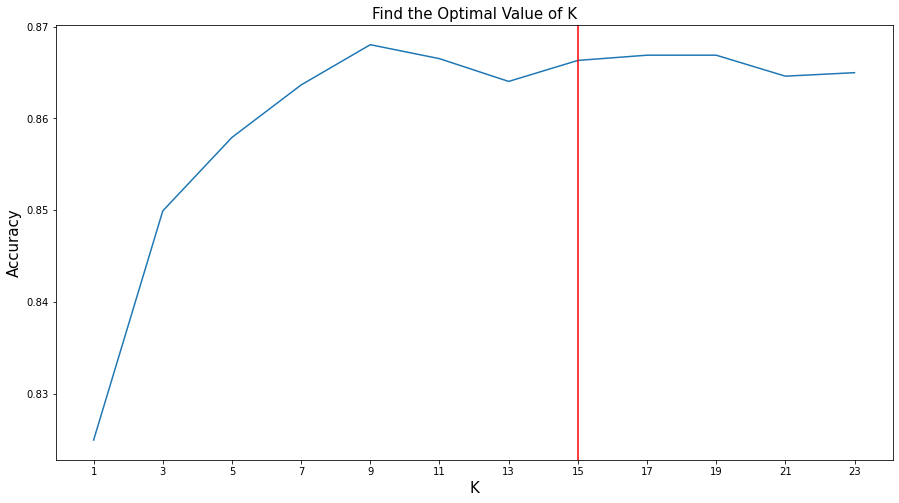

In [30]:
# plot the accuracy for different values of K 
plt.plot(range(1,25,2), accuracy)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Find the Optimal Value of K', fontsize = 15)
plt.xlabel('K', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)

# set the x-axis labels
plt.xticks(np.arange(1, 25, step = 2))

# plot a vertical line across the minimum error rate
plt.axvline(x = 15, color = 'red')

# display the plot
plt.show()

**Intrepretation:** The accuracy is stabilized after k = 15. Thus, we can consider 15 as the optimal value of k.